In [1]:
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.visualization
import named_arrays as na
import optika

In [2]:
radius_aperture = 100 * u.mm

In [3]:
f_number = 5

So the focal length of the primary is then

In [4]:
focal_length = f_number * radius_aperture
focal_length

<Quantity 500. mm>

In [5]:
sag_primary = optika.sags.ParabolicSag(-focal_length)

In [6]:
material_primary = optika.materials.Mirror()

In [7]:
aperture_primary = optika.apertures.CircularAperture(radius_aperture)

In [8]:
translation_primary = na.transformations.Cartesian3dTranslation(z=focal_length)

In [11]:
primary = optika.surfaces.Surface(
    name="primary",
    sag=sag_primary,
    material=material_primary,
    aperture=aperture_primary,
    transformation=translation_primary,
    is_pupil_stop=True,
)

In [12]:
width_pixel = 15 * u.um

In [13]:
num_pixel = na.Cartesian2dVectorArray(256, 256)

In [14]:
axis_pixel = na.Cartesian2dVectorArray("detector_x", "detector_y")

In [15]:
rotation_sensor = na.transformations.Cartesian3dRotationY(180 * u.deg)

In [16]:
sensor = optika.sensors.ImagingSensor(
    name="sensor",
    width_pixel=width_pixel,
    axis_pixel=axis_pixel,
    num_pixel=num_pixel,
    transformation=rotation_sensor
    is_field_stop=True,
)

In [17]:
pupil = na.Cartesian2dVectorLinearSpace(
    start=-1,
    stop=1,
    axis=na.Cartesian2dVectorArray("px", "py"),
    num=5,
    centers=True,
)

In [18]:
field = na.Cartesian2dVectorLinearSpace(
    start=-1,
    stop=1,
    axis=na.Cartesian2dVectorArray("fx", "fy"),
    num=5,
    centers=True,
)

In [19]:
wavelength = 500 * u.nm

In [20]:
grid_input = optika.vectors.ObjectVectorArray(
    wavelength=wavelength,
    field=field,
    pupil=pupil,
)

In [21]:
system = optika.systems.SequentialSystem(
    surfaces=[
        primary,
    ],
    sensor=sensor,
    grid_input=grid_input,
)

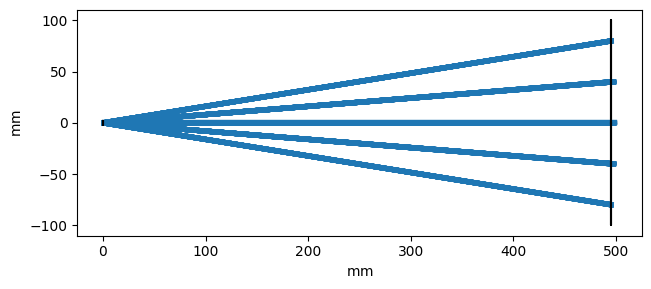

In [22]:
# plot the system
with astropy.visualization.quantity_support():
    fig, ax = plt.subplots(constrained_layout=True)
    ax.set_aspect("equal")
    system.plot(
        ax=ax,
        components=("z", "y"),
        kwargs_rays=dict(
            color="tab:blue",
        ),
        color="black",
        zorder=10,
    )

In [23]:
position = system.rayfunction_default.outputs.position.to(u.um)

In [24]:
position_relative = position - position.mean(pupil.axes)

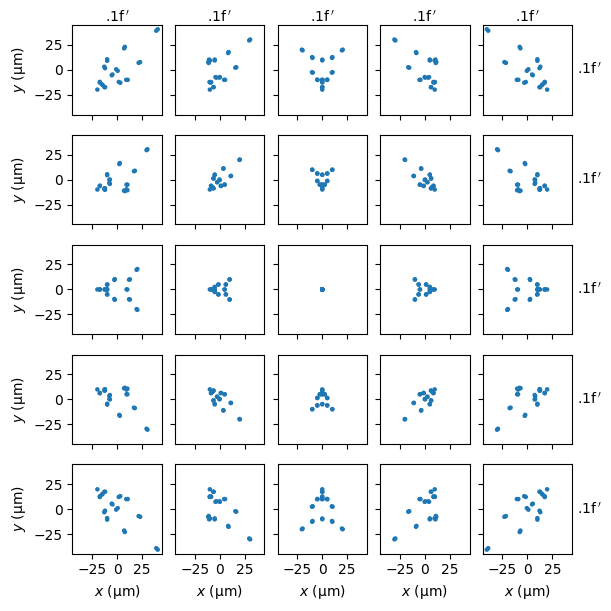

In [25]:
with astropy.visualization.quantity_support():
    fig, ax = na.plt.subplots(
        axis_rows=field.axis.y,
        axis_cols=field.axis.x,
        nrows=field.num,
        ncols=field.num,
        sharex=True,
        sharey=True,
        figsize=(6, 6),
        constrained_layout=True,
    )
    na.plt.scatter(
        position_relative.x,
        position_relative.y,
        ax=ax,
        s=5,
    )
    
    ax_lower = ax[{field.axis.y: +0}]
    ax_upper = ax[{field.axis.y: ~0}]
    ax_left = ax[{field.axis.x: +0}]
    ax_right = ax[{field.axis.x: ~0}]
    
    na.plt.set_aspect("equal", ax=ax)
    na.plt.set_xlabel(f"$x$ ({position.x.unit:latex_inline})", ax=ax_lower)
    na.plt.set_ylabel(f"$y$ ({position.y.unit:latex_inline})", ax=ax_left)
    
    angle = system.rayfunction_default.inputs.field.to(u.arcmin)
    angle_x = angle.x.mean(set(angle.axes) - {field.axis.x,})
    angle_y = angle.y.mean(set(angle.axes) - {field.axis.y,})
    na.plt.text(
        x=0.5,
        y=1,
        s=angle_x.to_string_array(".1f"),
        ax=ax_upper,
        transform=na.plt.transAxes(ax_upper),
        ha="center",
        va="bottom",
    )
    na.plt.text(
        x=1.05,
        y=0.5,
        s=angle_y.to_string_array(".1f"),
        ax=ax_right,
        transform=na.plt.transAxes(ax_right),
        ha="left",
        va="center",
    )